In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torchvision import transforms, datasets
import tensorflow as tf

image_generator = tf.keras.preprocessing.image.ImageDataGenerator
load_img = tf.keras.preprocessing.image.load_img
img_to_array = tf.keras.preprocessing.image.img_to_array

In [9]:
train_dir = 'data/Training'
test_dir = 'data/Testing'
val_dir = 'data/Validation'

In [59]:
train_datagen = image_generator(
    rescale=1./255,        # Normalize pixel values
    rotation_range=20,     # Example of data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [60]:
test_datagen = image_generator(rescale=1./255)

In [61]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # Resize images to this size
    batch_size=32,
    class_mode='binary'    # Use 'binary' for binary classification
)

Found 300 images belonging to 2 classes.


In [62]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 20 images belonging to 2 classes.


In [63]:
val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

Found 10 images belonging to 2 classes.


In [68]:
def create_dataset(directory, batch_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        image_size=(150, 150),
        batch_size=batch_size
    )
    return dataset

train_dataset = create_dataset('data/Training', batch_size=32)
val_dataset = create_dataset('data/Validation', batch_size=32)

train_dataset = train_dataset.repeat()
val_dataset = val_dataset.repeat()

Found 300 files belonging to 2 classes.
Found 10 files belonging to 2 classes.


Males images 150
Female images 150
Number of training samples: 300
Image shape (150, 150, 3)
Classes {'Female': 0, 'Male': 1}


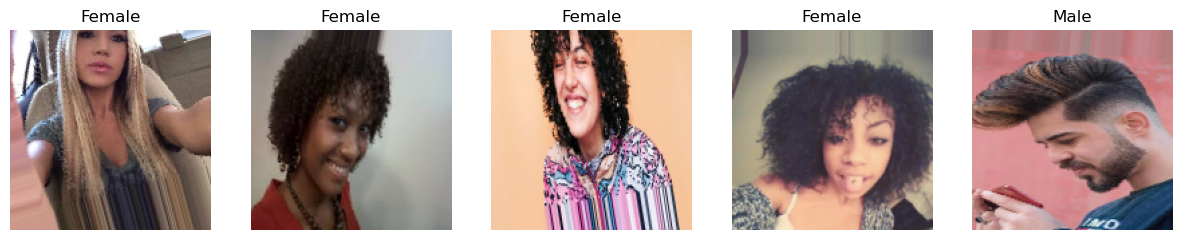

In [69]:
males = []
females = []

for x in train_generator.classes:
    if x == 0:
        females.append(x)
    else:
        males.append(x)

print('Males images', len(males))
print('Female images', len(females))

print('Number of training samples:', train_generator.samples)
print('Image shape', train_generator.image_shape)
print('Classes', train_generator.class_indices)

# Show random images from training dataset
images, labels = next(train_generator)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):
    ax = axes[i]
    ax.imshow(images[i])
    ax.axis('off')  
    label = 'Female' if labels[i] == 0 else 'Male'
    ax.set_title(label)

plt.show()

## Model Training

In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam

In [64]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid') # Binary classification
])

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [65]:
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [66]:
steps_per_epoch = (300 + 32 - 1) // 32
validation_steps = (10 + 32 - 1) // 32 

print(steps_per_epoch, validation_steps)

10 1


In [70]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_generator,
    validation_steps=validation_steps
)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 412ms/step - accuracy: 0.5552 - loss: 0.6611 - val_accuracy: 0.7000 - val_loss: 0.6130
Epoch 2/10


2024-09-04 21:32:48.788062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/miniconda3/envs/dsi_participant/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-09-04 21:32:48.799026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


AttributeError: 'NoneType' object has no attribute 'items'

#### Training results showes that the model achieved 87.5% accuracy on the training set and 80% accuracy on the validation set, with a loss of 0.4000 on the training set and 0.5257 on the validation set. We can increase epochs in the beginning to try if it will work for us. Also I will try to add more layers

In [51]:
# Check the number of samples and batch size
print('Training samples:', train_generator.samples)
print('Validation samples:', val_generator.samples)
print('Batch size:', train_generator.batch_size)

# Compute steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = val_generator.samples // val_generator.batch_size

print('Steps per epoch:', steps_per_epoch)
print('Validation steps:', validation_steps)


Training samples: 300
Validation samples: 10
Batch size: 32
Steps per epoch: 9
Validation steps: 0


In [46]:
history_2 = model.fit(
    train_generator,
    steps_per_epoch=9,
    epochs=15,  # Increase epochs as needed
    validation_data=val_generator,
    validation_steps=1
)

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 346ms/step - accuracy: 0.8443 - loss: 0.3803 - val_accuracy: 0.8000 - val_loss: 0.2998
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7188 - loss: 0.5443 - val_accuracy: 0.8000 - val_loss: 0.3076
Epoch 3/15


2024-09-04 21:16:27.960612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - accuracy: 0.8345 - loss: 0.3623 - val_accuracy: 0.8000 - val_loss: 0.3055
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8438 - loss: 0.3461 - val_accuracy: 0.8000 - val_loss: 0.3091
Epoch 5/15


2024-09-04 21:16:32.682817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 371ms/step - accuracy: 0.8580 - loss: 0.3273 - val_accuracy: 0.9000 - val_loss: 0.3989
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9688 - loss: 0.1515 - val_accuracy: 0.9000 - val_loss: 0.3337
Epoch 7/15


2024-09-04 21:16:37.444910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 438ms/step - accuracy: 0.8442 - loss: 0.3535 - val_accuracy: 0.9000 - val_loss: 0.3614
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8125 - loss: 0.3365 - val_accuracy: 0.9000 - val_loss: 0.3071
Epoch 9/15


2024-09-04 21:16:43.228785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step - accuracy: 0.8187 - loss: 0.4095 - val_accuracy: 0.8000 - val_loss: 0.5028
Epoch 10/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7500 - loss: 0.4973 - val_accuracy: 0.9000 - val_loss: 0.4093
Epoch 11/15


2024-09-04 21:16:47.661606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 350ms/step - accuracy: 0.9040 - loss: 0.3517 - val_accuracy: 0.8000 - val_loss: 0.2611
Epoch 12/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9062 - loss: 0.2843 - val_accuracy: 0.9000 - val_loss: 0.2816
Epoch 13/15


2024-09-04 21:16:52.394173: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 311ms/step - accuracy: 0.8489 - loss: 0.3001 - val_accuracy: 0.8000 - val_loss: 0.2850
Epoch 14/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8438 - loss: 0.2843 - val_accuracy: 0.8000 - val_loss: 0.2726
Epoch 15/15


2024-09-04 21:16:56.953100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 316ms/step - accuracy: 0.8672 - loss: 0.2657 - val_accuracy: 0.8000 - val_loss: 0.1888


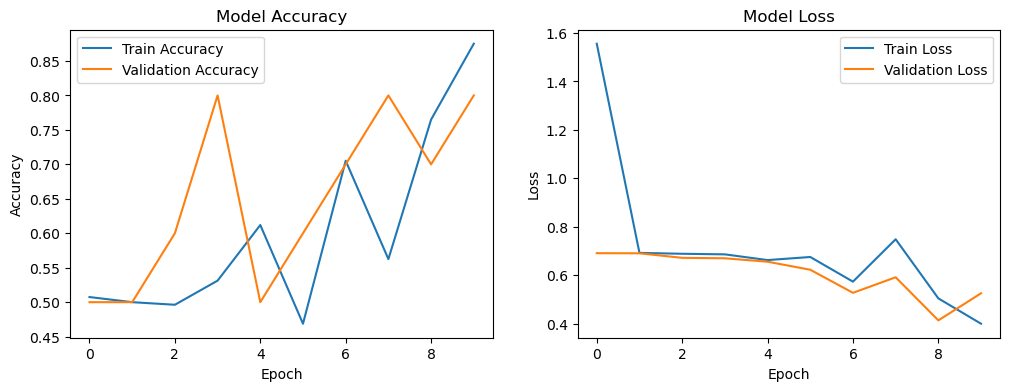

In [47]:
history_2 = model.history

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [49]:
# I will try to add more layers
from keras.layers import Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Adding dropout for regularization
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

/opt/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [50]:
history_3 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 450ms/step - accuracy: 0.5453 - loss: 1.1218 - val_accuracy: 0.5000 - val_loss: 0.7113
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5625 - loss: 0.6736 - val_accuracy: 0.5000 - val_loss: 0.7256
Epoch 3/10


2024-09-04 21:24:50.465276: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/miniconda3/envs/dsi_participant/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 486ms/step - accuracy: 0.6338 - loss: 0.6750 - val_accuracy: 0.6000 - val_loss: 0.6312
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5625 - loss: 0.6381 - val_accuracy: 0.6000 - val_loss: 0.6286
Epoch 5/10


2024-09-04 21:24:56.689739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 592ms/step - accuracy: 0.7452 - loss: 0.5158 - val_accuracy: 0.8000 - val_loss: 0.5455
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6875 - loss: 0.6465 - val_accuracy: 0.8000 - val_loss: 0.5191
Epoch 7/10


2024-09-04 21:25:03.692747: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 706ms/step - accuracy: 0.7851 - loss: 0.5148 - val_accuracy: 0.8000 - val_loss: 0.4019
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8125 - loss: 0.4821 - val_accuracy: 0.8000 - val_loss: 0.4120
Epoch 9/10


2024-09-04 21:25:11.673513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 522ms/step - accuracy: 0.8473 - loss: 0.4667 - val_accuracy: 0.8000 - val_loss: 0.4530
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8750 - loss: 0.3323 - val_accuracy: 0.8000 - val_loss: 0.4680


2024-09-04 21:25:18.906612: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
